In [84]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,cross_val_score

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotNormal

Handling the preprocessing of both training and test datasets

In [87]:


def data_preprocessing(train_file: str, test_file: str = None) -> tuple:
    """
    Preprocess both training and test data consistently.
    
    Parameters:
    train_file (str): Path to training data file
    test_file (str): Path to test data file (optional)
    
    Returns:
    tuple: (processed_train_df, processed_test_df) if test_file is provided
           processed_train_df if test_file is None
    """
    # Define valid ranges for each feature
    valid_ranges = {
        'acousticness': (0.0, 1.0),
        'danceability': (0.0, 1.0),
        'energy': (0.0, 1.0),
        'instrumentalness': (0.0, 1.0),
        'liveness': (0.0, 1.0),
        'loudness': (-60.0, 0.0),
        'speechiness': (0.0, 1.0),
        'valence': (0.0, 1.0),
        'tempo': (0.0, np.inf),
        'key': (0, 11),
        'mode': (0, 1)
    }
    
    # Columns to standardize
    columns_to_standardize = [
        'acousticness', 'danceability', 'instrumentalness',
        'liveness', 'loudness', 'speechiness', 'valence', 'tempo'
    ]
    
    # Read and process training data
    df_train = pd.read_csv(train_file)
    
    # Check and filter values within valid ranges
    for column, (min_val, max_val) in valid_ranges.items():
        df_train = df_train[(df_train[column] >= min_val) & (df_train[column] <= max_val)]
    
    # Convert mode values
    df_train['mode'] = df_train['mode'].replace({0: -1, 1: 1})
    
    # Drop key column
    df_train = df_train.drop(columns=['key'])
    
    # Fit scaler on training data and transform
    scaler = StandardScaler()
    df_train[columns_to_standardize] = scaler.fit_transform(df_train[columns_to_standardize])
    
    # Handle missing values
    df_train = df_train.dropna()
    
    # If no test file is provided, return only training data
    if test_file is None:
        return df_train
    
    # Process test data using the same transformations
    df_test = pd.read_csv(test_file)
    
    # Apply same range filtering
    for column, (min_val, max_val) in valid_ranges.items():
        df_test = df_test[(df_test[column] >= min_val) & (df_test[column] <= max_val)]
    
    # Convert mode values
    df_test['mode'] = df_test['mode'].replace({0: -1, 1: 1})
    
    # Drop key column
    df_test = df_test.drop(columns=['key'])
    
    # Transform test data using the fitted scaler
    df_test[columns_to_standardize] = scaler.transform(df_test[columns_to_standardize])
    
    # Handle missing values
    df_test = df_test.dropna()
    
    return df_train, df_test





<class 'pandas.core.frame.DataFrame'>
Index: 502 entries, 0 to 504
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      502 non-null    float64
 1   energy            502 non-null    float64
 2   loudness          502 non-null    float64
 3   mode              502 non-null    int64  
 4   speechiness       502 non-null    float64
 5   acousticness      502 non-null    float64
 6   instrumentalness  502 non-null    float64
 7   liveness          502 non-null    float64
 8   valence           502 non-null    float64
 9   tempo             502 non-null    float64
 10  Label             502 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 47.1 KB
None
(502, 10)


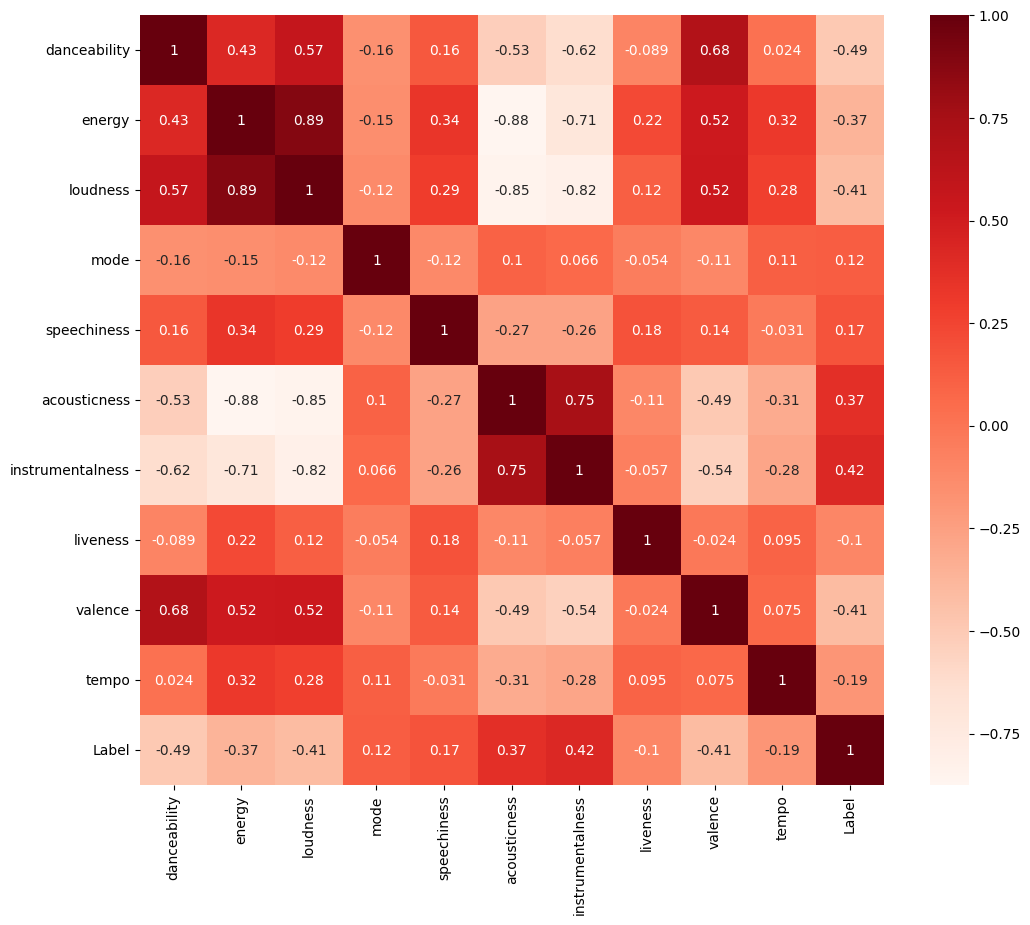

In [88]:

df =data_preprocessing('project_train.csv')


print(df.info())


#Prepare data 
X = df.drop('Label',axis =1)

y = df['Label']
print(X.shape)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2,random_state =42)
# plot correlation matrix  
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


## TRAIN Decision Tree

In [8]:
def train_decision_tree(X_train,X_val,y_train,y_val):
    param_grid = {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    decision_tree = DecisionTreeClassifier(random_state =42)
    grid_search = GridSearchCV(decision_tree,param_grid,cv = 5 ,scoring  = 'accuracy')
    grid_search.fit(X_train,y_train)
    
    best_decsion_tree = grid_search.best_estimator_
    y_pred = best_decsion_tree.predict(X_val)
    
    print("Decision Tree Results:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print(classification_report(y_val, y_pred))
    return best_decsion_tree
    
    

best_decision_tree = train_decision_tree(X_train,X_val,y_train,y_val)

Decision Tree Results:
Best parameters: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2}
Validation Accuracy: 0.7822
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        52
           1       0.81      0.71      0.76        49

    accuracy                           0.78       101
   macro avg       0.79      0.78      0.78       101
weighted avg       0.79      0.78      0.78       101



##  TRAIN RANDOM FORREST

In [80]:
def train_random_forrest(X_train,X_val,y_train,y_val):
    param_grid = {
        'n_estimators' : [100,200,300],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    custom_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    rf = RandomForestClassifier(random_state =42)
    grid_search = GridSearchCV(rf,param_grid,cv =custom_cv ,scoring  = 'accuracy',n_jobs=-1)
    grid_search.fit(X_train,y_train)
    
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_val)
    best_index = grid_search.best_index_
    print("Decision Tree Results:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best parameters mean" , grid_search.cv_results_['mean_test_score'][best_index])
    print(f"Best parameters std" , grid_search.cv_results_['std_test_score'][best_index])
    print(f"Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print(classification_report(y_val, y_pred))
    
    return best_rf


best_rf = train_random_forrest(X_train,X_val,y_train,y_val)


Decision Tree Results:
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best parameters mean 0.8452469135802468
Best parameters std 0.030657859662598794
Validation Accuracy: 0.8218
              precision    recall  f1-score   support

           0       0.79      0.88      0.84        52
           1       0.86      0.76      0.80        49

    accuracy                           0.82       101
   macro avg       0.83      0.82      0.82       101
weighted avg       0.83      0.82      0.82       101



# TRAIN XGBOOST

In [ ]:
def train_xgboost(X_train, y_train, X_val, y_val):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    xgb = XGBClassifier(random_state=42, eval_metric='logloss')
    custom_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy',n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_xgb = grid_search.best_estimator_
    y_pred = best_xgb.predict(X_val)
    best_index = grid_search.best_index_
    print("\nXGBoost Results:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best parameters mean" , grid_search.cv_results_['mean_test_score'][best_index])
    print(f"Best parameters std" , grid_search.cv_results_['std_test_score'][best_index])
    print(f"Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print(classification_report(y_val, y_pred))
    
    return best_xgb
 

best_xgboost = train_xgboost(X_train,y_train,X_val, y_val)

#print confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix(y_val, best_xgboost.predict(X_val)), annot=True, fmt='d', cmap='Blues')
plt.title('XG Boost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

We analyze how XGBoost and Random Forest perform with different numbers of PCA components.
We run multiple iterations with different random states to ensure robust results and visualize 
 the performance trends.

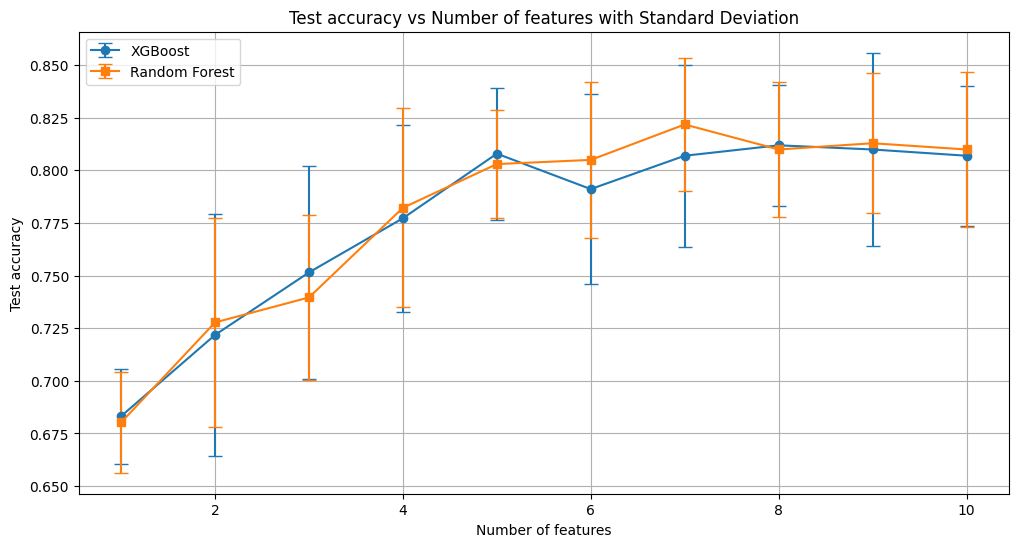

Best number of features for XGBoost: 8
Best number of features for Random Forest: 7


In [83]:


def perform_analysis(X, y, model_type, param_grid):
    # Custom cross-validation strategy
    custom_cv = StratifiedKFold(n_splits=5)

    # Initialize lists to store accuracies and standard deviations
    accuracies_test = [[] for _ in range(10)]

    # Draw distinct random states
    np.random.seed(0)
    random_states = np.random.randint(0, 1000, 10)
    
    # Perform the grid search for each random state
    for random_state in random_states:    
        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

        # Loop over the number of features to reduce using PCA
        for nb_features in range(1, 11):
            # Perform PCA
            pca = PCA(n_components=nb_features)
            X_train_pca = pca.fit_transform(X_train)
            X_test_pca = pca.transform(X_test)
            
            # Initialize and perform the grid search
            if model_type == 'xgboost':
                model = XGBClassifier(random_state=random_state)
            else:  # Random Forest
                model = RandomForestClassifier(random_state=random_state)
            
            grid_search = GridSearchCV(model, param_grid, cv=custom_cv, scoring='accuracy',n_jobs=-1)
            grid_search.fit(X_train_pca, y_train)
            
            # Get the best model and evaluate on test set
            best_model = grid_search.best_estimator_
            test_accuracy = best_model.score(X_test_pca, y_test)
            
            # Store the test accuracy for each feature set
            accuracies_test[nb_features-1].append(test_accuracy)

    # Calculate the mean and standard deviation for each number of features
    mean_accuracies = [np.mean(acc) for acc in accuracies_test]
    std_accuracies = [np.std(acc) for acc in accuracies_test]

    return mean_accuracies, std_accuracies

# Define parameter grids for XGBoost and Random Forest
xgb_param_grid = {
       'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
}

rf_param_grid = {
      'n_estimators' : [100,200,300],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
}

# Perform analysis for XGBoost and Random Forest
xgb_mean, xgb_std = perform_analysis(X, y, 'xgboost', xgb_param_grid)
rf_mean, rf_std = perform_analysis(X, y, 'random_forest', rf_param_grid)

# Plot the results
plt.figure(figsize=(12, 6))

plt.errorbar(range(1, 11), xgb_mean, yerr=xgb_std, fmt='-o', capsize=5, label='XGBoost')
plt.errorbar(range(1, 11), rf_mean, yerr=rf_std, fmt='-s', capsize=5, label='Random Forest')

plt.xlabel('Number of features')
plt.ylabel('Test accuracy')
plt.title('Test accuracy vs Number of features with Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best number of features for XGBoost: {np.argmax(xgb_mean) + 1}")
print(f"Best number of features for Random Forest: {np.argmax(rf_mean) + 1}")







# TRAIN NEURAL NETWORK

C:\Users\FisherMoon25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4865 - loss: 0.7599 - val_accuracy: 0.6535 - val_loss: 0.5404
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7910 - loss: 0.4775 - val_accuracy: 0.7822 - val_loss: 0.4957
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7910 - loss: 0.4481 - val_accuracy: 0.7723 - val_loss: 0.4706
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7700 - loss: 0.4741 - val_accuracy: 0.7624 - val_loss: 0.4587
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7500 - loss: 0.4839 - val_accuracy: 0.7822 - val_loss: 0.4530
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8190 - loss: 0.4178 - val_accuracy: 0.7723 - val_loss: 0.4489
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8691 - loss: 0.3584 - val_accuracy: 0.7921 - val_loss: 0.4523
Epoch 8/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8143 - loss: 0.4467 - val_accuracy: 0.8020 - 

C:\Users\FisherMoon25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4239 - loss: 0.8068 - val_accuracy: 0.5050 - val_loss: 0.7192
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4857 - loss: 0.7551 - val_accuracy: 0.6040 - val_loss: 0.6695
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5382 - loss: 0.7257 - val_accuracy: 0.6337 - val_loss: 0.6303
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6144 - loss: 0.6488 - val_accuracy: 0.6634 - val_loss: 0.6002
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6426 - loss: 0.6227 - val_accuracy: 0.6535 - val_loss: 0.5799
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6887 - loss: 0.5817 - val_accuracy: 0.6535 - val_loss: 0.5638
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6817 - loss: 0.5841 - val_accuracy: 0.6535 - val_loss: 0.5471
Epoch 8/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6890 - loss: 0.5609 - val_accuracy: 0.7030 - val_loss: 0.

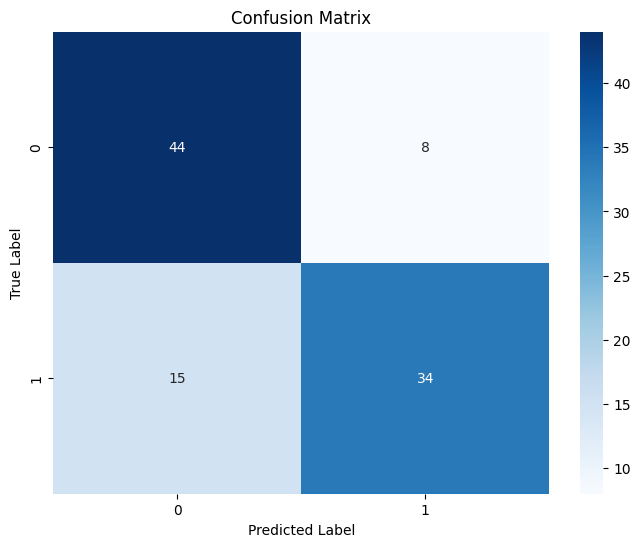

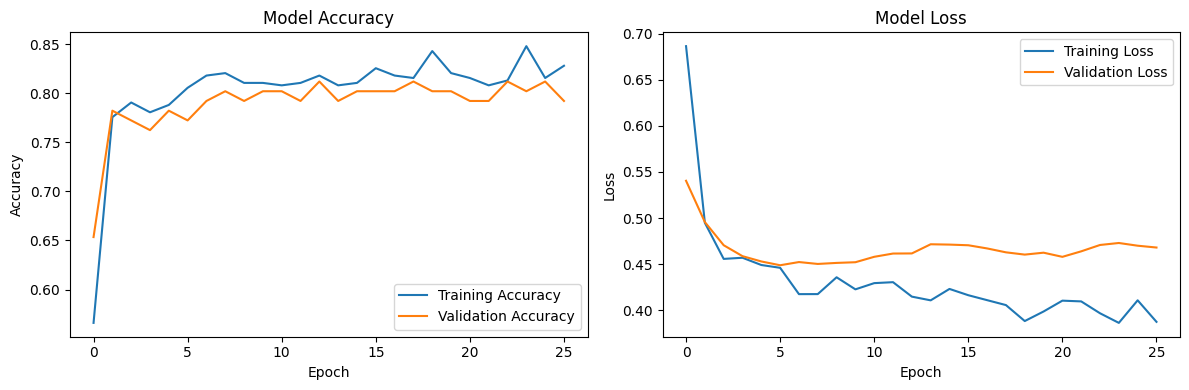

In [88]:


def create_model(input_shape):
    model = Sequential([
        Dense(64, activation='tanh', input_shape=input_shape,kernel_initializer=GlorotNormal()),
        Dropout(0.2),
        Dense(32, activation='tanh',kernel_initializer=GlorotNormal()),
        Dropout(0.2),
        Dense(16, activation='tanh',kernel_initializer=GlorotNormal()),
        Dense(1, activation='sigmoid',kernel_initializer=GlorotNormal())
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create the model
input_shape = (X_train.shape[1],)
model = create_model(input_shape)
model.summary()


# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True,min_delta = 0.000001)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size = 20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f"Test accuracy: {test_accuracy:.4f}")




# Create a new model with the same architecture
fine_tuned_model = create_model(input_shape)

custom_optimizer = Adam(learning_rate=0.0001)

fine_tuned_model.compile(optimizer=custom_optimizer,
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

# Train the fine-tuned model
history_fine_tuned = fine_tuned_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the fine-tuned model
test_loss, test_accuracy = fine_tuned_model.evaluate(X_val, y_val)
print(f"Fine-tuned model test accuracy: {test_accuracy:.4f}")



# Make predictions
y_pred = (model.predict(X_val) > 0.5).astype(int)

# Print classification report
print(classification_report(y_val, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# Make prediction using XGBoost

In [90]:
X_test = data_preprocessing('project_test.csv')


        
# Generate predictions
output_path = 'predictions.csv'
predictions = best_xgboost.predict(X_test)
        
# Create and save predictions DataFrame
predictions_df = pd.DataFrame({'prediction': predictions})
predictions_df.to_csv(output_path, index=False)
        